In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from model import list_entropy, mutual_information
import seaborn as sns
sns.set_context("talk")

In [4]:
class CRP(object):
    
    def __init__(self, alpha, max_goals=4):
        self.alpha = alpha
        self.cluster_assignments = dict()
        
    def update(self, c, k):
        self.cluster_assignments[c] = k
        
    def predict(self):
        """ generate a cluster prediction for context n+1"""
        t = len(self.cluster_assignments)
        pmf = np.zeros(t+1)
        for k in set(self.cluster_assignments.values()):
            N_k = np.sum(np.array(self.cluster_assignments.values()) == k)
            pmf[k] = N_k / (t + self.alpha)
        pmf[-1] = self.alpha / (t + self.alpha)
        return pmf / pmf.sum()
    
    def predict_goal(self):
        pmf = self.predict()
        #number of goals seen
        n_g = min(len(self.cluster_assignments.values()), 4)
        chance_prob = 1 - pmf[:n_g].sum()
        
        goal_prediction_pmf = np.zeros(4)
        for g in range(n_g):
            goal_prediction_pmf[g] = pmf[g]
        goal_prediction_pmf += (chance_prob / 4.)
        
        return goal_prediction_pmf
        
def relabel(context_goals):
    visited_goals = dict()
    relabeled = list()
    g_max = 0
    for g in context_goals:
        if g not in visited_goals.keys():
            visited_goals[g] = g_max
            g_max += 1
        g0 = visited_goals[g]
        relabeled.append(g0)
    return relabeled

def make_dict(context_goals):
    _context_goals = relabel(context_goals)
    return {c: k for c, k in enumerate(_context_goals)}
    
def evaluate(context_goals, alpha=1.0):
    context_goal_pairs = make_dict(context_goals)
    crp = CRP(alpha=alpha)

    goal_guesses = 0
    n_guesses = 0
    for c, k in context_goal_pairs.iteritems():
        crp_pmf = crp.predict_goal()
        goal_guesses -= np.log2(crp_pmf[k])
        crp.update(c, k)
        n_guesses += 1
    return goal_guesses / n_guesses

def evaluate_joint(context_goals, context_maps, alpha=1.0):
    context_goal_pairs = make_dict(context_maps)
    context_map_pairs = make_dict(context_goals)
    
    crps = [CRP(alpha=alpha) for _ in set(context_map_pairs.values())]
    goal_guesses = 0
    n_guesses = 0
    for m, crp in enumerate(crps):
        # create a list of goals conditional on each map
        context_goal_pairs = make_dict(
            [g for g, m0 in zip(context_goals, context_maps) if m0 == m]
        ) 
    
        for c, k in context_goal_pairs.iteritems():
            crp_pmf = crp.predict_goal()
            goal_guesses -= np.log2(crp_pmf[k])
            crp.update(c, k)
            n_guesses += 1
            
    
    return goal_guesses / n_guesses
        

def plot_evaluate(context_goals):
    print "Entropy H(Goal):           %.2f" % list_entropy(context_goals)
    plt.figure(figsize=(8, 5))
    x = np.arange(0.10, 10.0, 0.05)
    h = [evaluate(context_goals, alpha=x0) for x0 in x]
    handle_ind, = plt.plot(x, h, label='Goal Clustering')

    chance_probability = np.log2(len(set(context_goals)))
    handle_ub, = plt.plot([0, 10], [chance_probability, chance_probability], 'k:',
            label='Uniform Guess over Goals')
    
    lower_bound = list_entropy(context_goals)
    handle_lb0, = plt.plot([0, 10], [lower_bound, lower_bound], 'k--',
            label='Entropy of Pr(Goal)')
    ax = plt.gca()
    ax.set_position([0.1,0.1,0.5,0.8])
    plt.legend(handles=[handle_ind, handle_ub, handle_lb0], loc='center left', bbox_to_anchor = (1.0, 0.5))


def plot_evaluate_joint(context_goals, context_maps):
    print "Entropy H(Goal):           %.2f" % list_entropy(context_goals)
    print "Entropy H(Enviornment):    %.2f" % list_entropy(context_maps)
    print "Mutual Information I(G,E): %.2f" % mutual_information(context_goals, context_maps)
    
    plt.figure(figsize=(8, 5))
    x = np.arange(0.10, 10.0, 0.05)
    h_ind = [evaluate(context_goals, alpha=x0) for x0 in x]
    h_joint = [evaluate_joint(context_goals, context_maps, alpha=x0)
              for x0 in x]
    handle_ind, = plt.plot(x, h_ind, label='Independent Goal Clustering')
    handle_joint, = plt.plot(x, h_joint, 'r', label='Conditional Goal Clustering')
    
    chance_probability = np.log2(len(set(context_goals)))
    handle_ub, = plt.plot([0, 10], [chance_probability, chance_probability], 'k:',
            label='Uniform Guess over Goals)')
    
    independent_lower_bound = list_entropy(context_goals)
    handle_lb0, = plt.plot([0, 10], [independent_lower_bound, independent_lower_bound], 'k--',
            label='Entropy of Pr(Goal)')
    
    conditional_lower_bound = list_entropy(context_goals) - \
            mutual_information(context_goals, context_maps)
        
    handle_lb1, = plt.plot([0, 10], [conditional_lower_bound, conditional_lower_bound], 'k',
            label='Entropy of Pr(Goal|Envoirnment)')
    ax = plt.gca()
    ax.set_position([0.1,0.1,0.5,0.8])
    plt.legend(handles=[handle_ind, handle_joint, handle_ub, handle_lb0, handle_lb1],
               loc='center left', bbox_to_anchor = (1.0, 0.5))

# Evaluation of the Prior over reward functions

Here, we are consered with the efficacy of generalization. One way to evaluate the value of generalization is to evalute how well a generalizater "guesses" in a new context. Here, we consider the case when the agent has to guess which "goal" is correct in a new context.


Let $g \in G = \{g_1, g_2, ...\}$ be a discrete goal the agent is trying to guess, and let $c\in \mathcal{C}=\{c_1, c_2, ...\}$ be the context. We will assume that for each new context, the goals are distributed by the exchanagle distribution $p$, such that the probability goal $g$ is selected in the new context $c_{t+1}$ is defined:
$$ p_{g_i} = \Pr(g=g_i | c_{t+1})$$

Our generalizing agent, on the other hand, proposes distribution $q_{g_i} = \Pr(g=g_i|c_{t+1}) $ as its prior over goals in the new context $c_{t+1}$. This prior acts as a guess over goals, and the best possible guess is $q=p$. 

### Information content of the prior
We can evaluate the quality of $q$ as a prior by the degree of surprise for each new goal. Formally, this is the information content of the goal, which is defined as $h$:
$$ h(g|q) = \log_2 \frac{1}{q_g}$$
and its expecation, the entropy of $q$:
$$ \text{H}(q) = \sum_{g} q_g\log_2 \frac{1}{q_g}$$

Lower values of information (surprise) signify a better guess, and the value is minimized when  $p=q$. Consequently, the theoretical lower limit of the surprise is the entropy of the true distribution of goals:
$$ \text{H}(p) = \sum_{g} p_g\log_2 \frac{1}{p_g}$$

For an upper bound, the entropy of a uniform prior, $\text{H}(u) = \sum_{g} \frac{1}{||G||}\log_2 \frac{1}{1/||G||}$ is a reasonable limit.

Consequently, we can say that the agent benefits from generlization if $\text{H}(q) < \text{H}(u)$, and we can expect $\text{H}(q) \geq \text{H}(p)$.

Entropy H(Goal):           2.00


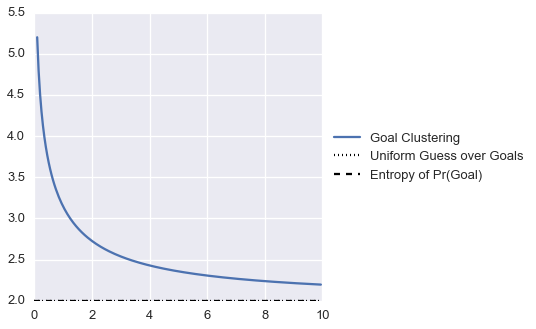

In [6]:
context_goals = [0, 1, 2, 3]
plot_evaluate(context_goals)

Entropy H(Goal):           1.55


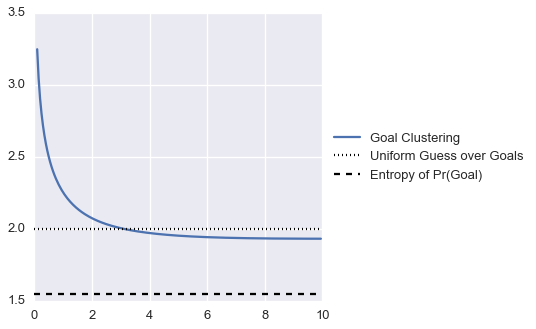

In [57]:
context_goals = [0] * 5 + [1, 2, 3]
plot_evaluate(context_goals)

Entropy H(Goal):           1.15


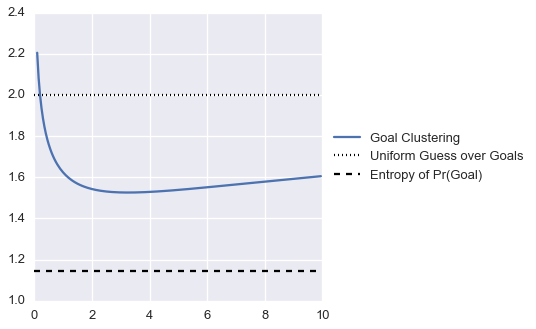

In [58]:
context_goals = [0] * 10 + [1, 2, 3]
plot_evaluate(context_goals)

The lower the entropy of the goal distribution, the more valuable in general it is to cluster

In [10]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize

upperbound = np.log2(4)

h_p = list()
generalization_benefit = list()
best_alpha = list()
for repeats in range(1, 200):
    context_goals = [0] * repeats + range(1, 4)
    def f0(alpha):
        return evaluate(context_goals, alpha=alpha)
    res = minimize(f0, 1.0)
    
    
    generalization_benefit.append(upperbound-res.fun)
    best_alpha.append(res.x)
    h_p.append(list_entropy(context_goals))

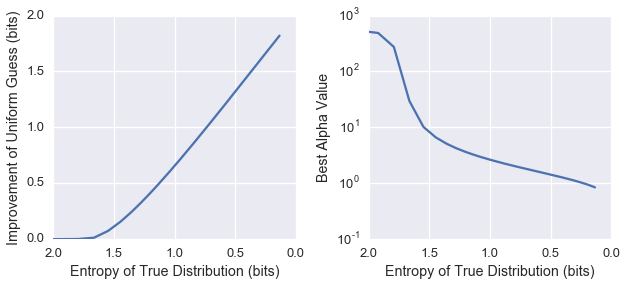

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(h_p, generalization_benefit)
axes[0].set_xlim(2, 0)
axes[0].set_xlabel('Entropy of True Distribution (bits)')
axes[0].set_ylim(0, 2)
axes[0].set_ylabel('Improvement of Uniform Guess (bits)')

axes[1].plot(h_p, best_alpha)
axes[1].set_xlim(2, 0)
axes[1].set_yscale('log')
axes[1].set_xlabel('Entropy of True Distribution (bits)')
axes[1].set_ylabel('Best Alpha Value')

# The CRP is an unbiased estimator (asymptotically)

One question we can ask about our generalizaiton model is whether it is a good 
estimate of the true statistics of the world. Specifically, we can ask whether 
it gives an *unbiased* estimate of the underlying statistics. Formally, the bias 
of an estimator $\hat \theta$ is the difference between the expectation of the 
estimate and the true values $theta$:

$\text{Bias}_\theta[\hat \theta] = \mathop{\mathbb{E}}_\theta \left [\hat \theta \right]-\theta$


We can say that an estimator is an unbiased estimator if and only if $\text{Bias}_\theta[\hat \theta] =0$. If we think of the CRP as an estimator of the unknown probability distribution of future contexts $q=\hat p$, then the CRP is a *baised* estimator of $p$, with its bias equal to the probability it gives to new clusters:

$\text{Bias}_p[q] = \frac{-\alpha}{\alpha + N_c}$

where $N_c$ is the total number of contexts the CRP has encountered. Fortunately, the bias
of the estimator decreases as a function of $N_c$, such that as the number of contexts experienced goes to infinity, $\text{Lim}_{N_c\to \infty}\left [\alpha/(\alpha + N_c)\right ]=0$ and the estimator becomes unbiased.

## Empirical Demonstration
Here, we show that the CRP becomes a better estimator of the underlying distribution as 
$N_c$ increases

/Users/nickfranklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in log2


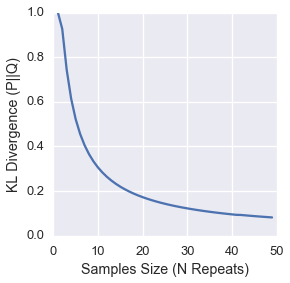

In [55]:
#minimize the alpha for each goal sequence
lowerbound = np.log2(2)

def kl_divergence(context_goals, pmf, alpha=1.0):
    context_goal_pairs = make_dict(context_goals)
    crp = CRP(alpha=alpha)

    goal_guesses = 0
    n_guesses = 0
    for c, k in context_goal_pairs.iteritems():
        crp_pmf = crp.predict_goal()
        goal_guesses += np.log2(pmf[k] / crp_pmf[k])
        crp.update(c, k)
        n_guesses += 1
    return goal_guesses / n_guesses    

sample_size = list()
generalization_benefit = list()
best_alpha = list()
for repeats in range(1, 50):
    context_goals = [0, 1] * repeats
    
    p = [0.5, 0.5, 0, 0]  # this is the "true" distribution over goals 1-4
    
    def f0(alpha):
        return evaluate(context_goals, alpha=alpha)
    res = minimize(f0, 1.0)
    
    generalization_benefit.append(kl_divergence(context_goals, p, alpha=res.x))
    sample_size.append(repeats)
    
fig = plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=0.3)
ax = plt.gca()
ax.plot(sample_size, generalization_benefit)
ax.set_xlabel('Samples Size (N Repeats)')
ax.set_ylim(0, 1)
ax.set_ylabel('KL Divergence (P||Q)')

## Goal predictions conditional on enviornment models

An agent moving exploring an enviornment will typically gain experience in that enviornment early, whereas it may only recieve rewards later. If this is the case, it may or may not be useful to guess about goal distribuiton using conditional on the envoirnmental experience.

let $p_g$ be the true distributions of goals for context $c_{t+1}$ and let $p_e$ be the true distribution of enviornments for context $c_{t+1}$. If $p_g$ and $p_e$ are known, than the agent is always better using $p_e$ to infer $p_g$. In this case, the lower bound is:

$$\text{H}(g|e) = \text{H}(g) - \text{I}(g|e)$$ 

The mutual information, $\text{I}(g, e)$, is a non-negative quanity that measure the degree of information shared between $g$ and $e$, that is, the degree to which knowledge of one informs knowledge of the other.

## Independent Clustering
None the less, it is not always the case that clustering goals conditionally on enviornments provides a better guess. In the example below, independent clustering strictly dominates clustering goals conditionally overall values of $\alpha$, and both show a generalization benefit wehn $\alpha > 4$.

Notice, the mutual information here is low.

Entropy H(Goal):           1.84
Entropy H(Enviornment):    0.86
Mutual Information I(G,E): 0.18


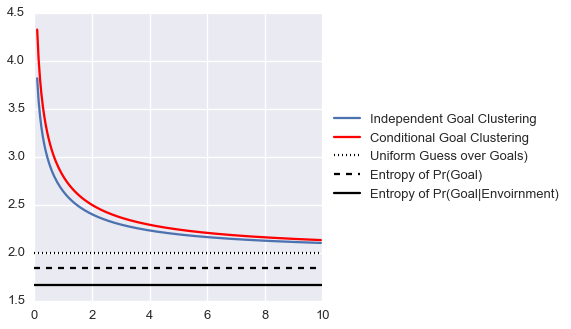

In [12]:
context_goals = [0, 0, 1, 2, 3, 0, 3]
context_maps  = [0, 0, 0, 0, 0, 1, 1]
plot_evaluate_joint(context_goals, context_maps)

### Conditionally Clustering
When the mutual information is high, joint clustering is great!

Entropy H(Goal):           1.92
Entropy H(Enviornment):    0.92
Mutual Information I(G,E): 0.92


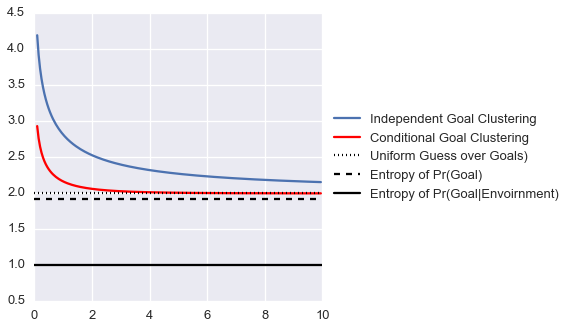

In [13]:
context_goals = [0, 1, 2, 3, 0, 3]
context_maps  = [0, 1, 1, 0, 0, 0]
plot_evaluate_joint(context_goals, context_maps)

### Conditionally Clustering
When the mutual information is high, joint clustering is great!

Entropy H(Goal):           1.42
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.00


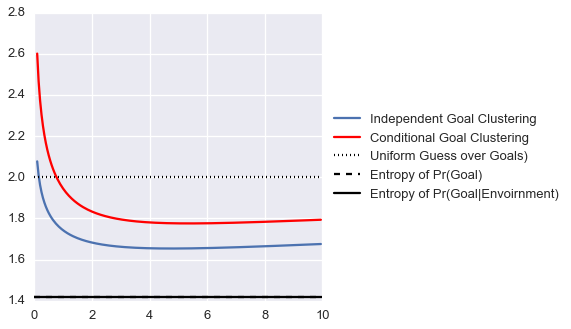

In [14]:
context_goals = [0] * 16 + [1] * 4 + [2] * 2 + [3] * 2
context_maps = [0, 1] * (len(context_goals) / 2)
plot_evaluate_joint(context_goals, context_maps)

Entropy H(Goal):           1.42
Entropy H(Enviornment):    4.25
Mutual Information I(G,E): 1.08


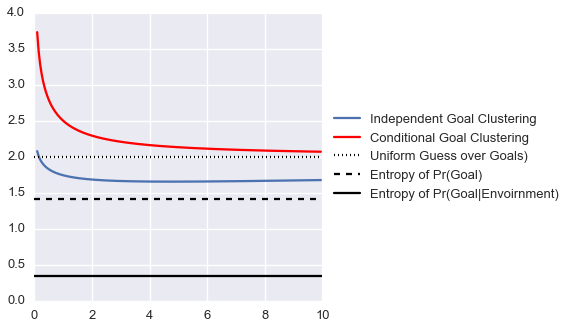

In [59]:
context_goals = [0] * 16 + [1] * 4 + [2] * 2 + [3] * 2
context_maps = range(len(context_goals)-5) * 2

plot_evaluate_joint(context_goals, context_maps)

# systematic attempt at quantifying I

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.53


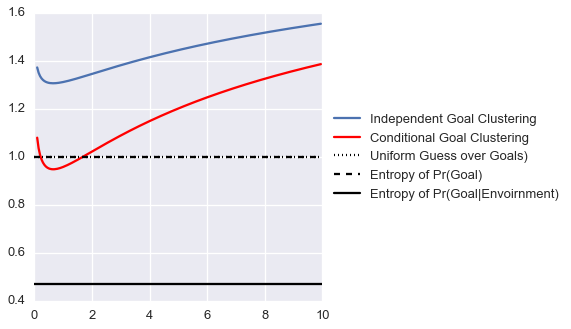

In [62]:
def comp_mi_conflict(N, n):
    context_goals = [0] * N + [1] * N 
    context_maps = [0] * (n) + [1]*(N-n) + [1] * n + [0] *(N-n)
    plot_evaluate_joint(context_goals, context_maps)
comp_mi_conflict(10, 9)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.00


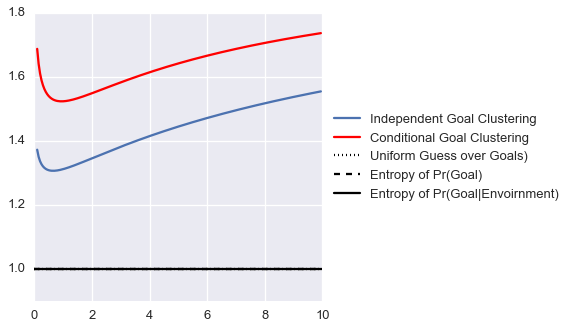

In [63]:
comp_mi_conflict(10, 5)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.12


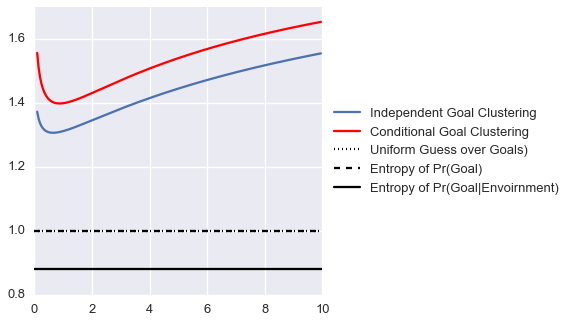

In [64]:
comp_mi_conflict(10, 7)

Entropy H(Goal):           1.00
Entropy H(Enviornment):    1.00
Mutual Information I(G,E): 0.12


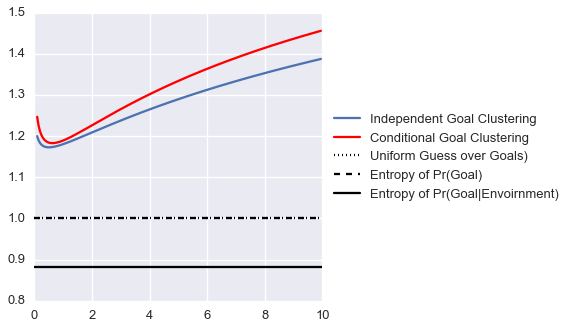

In [65]:
comp_mi_conflict(20, 14)

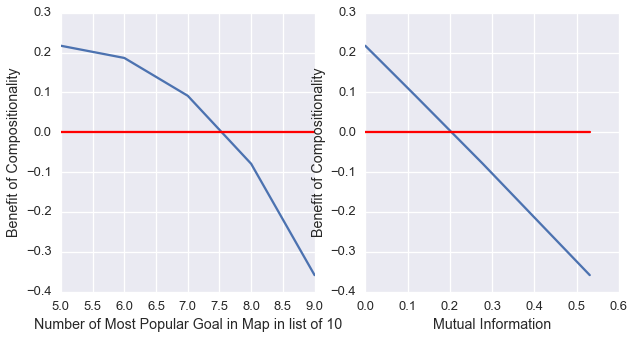

In [35]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 10
n_conflict = range(N/2, N)
compositionality_benefit = list()
mutual_information_list = list()

for n in n_conflict:
    
    context_goals = [0] * N + [1] * N 
    context_maps = [0] * (n) + [1] * (N-n) + [1] * n + [0] * (N-n)
    def f0(alpha):
        return evaluate(context_goals, alpha=alpha)
    res0 = minimize(f0, 1.0)
    
    def f1(alpha):
        return evaluate_joint(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 1.0)
    
    mutual_information_list.append(mutual_information(context_goals, context_maps))
    
    compositionality_benefit.append(res1.fun - res0.fun)
    h_p.append(list_entropy(context_goals))
    

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(n_conflict, compositionality_benefit)
axes[0].plot(n_conflict, [0]*len(n_conflict), 'r')
axes[0].set_ylabel('Benefit of Compositionality')
axes[0].set_xlabel('Number of Most Popular Goal in Map in list of 10')

axes[1].plot(mutual_information_list, compositionality_benefit)
axes[1].plot(mutual_information_list, [0]*len(mutual_information_list), 'r')
axes[1].set_ylabel('Benefit of Compositionality')
axes[1].set_xlabel('Mutual Information')

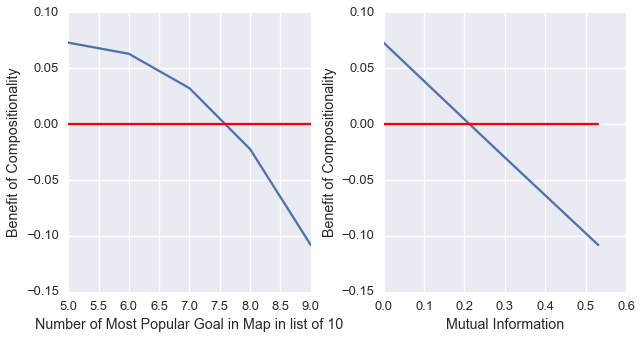

In [73]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 10
n_conflict = range(N/2, N)
compositionality_benefit = list()
mutual_information_list = list()

for n in n_conflict:
    
    context_goals = [0] * N + [1] * N 
    context_maps = [0] * (n) + [1] * (N-n) + [1] * n + [0] * (N-n)
    def f0(alpha):
        return evaluate_cost(context_goals, alpha=alpha)
    res0 = minimize(f0, 1.0)
    
    def f1(alpha):
        return evaluate_joint_cost(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 1.0)
    
    mutual_information_list.append(mutual_information(context_goals, context_maps))
    
    compositionality_benefit.append(res1.fun - res0.fun)
    h_p.append(list_entropy(context_goals))
    

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(n_conflict, compositionality_benefit)
axes[0].plot(n_conflict, [0]*len(n_conflict), 'r')
axes[0].set_ylabel('Benefit of Compositionality')
axes[0].set_xlabel('Number of Most Popular Goal in Map in list of 10')

axes[1].plot(mutual_information_list, compositionality_benefit)
axes[1].plot(mutual_information_list, [0]*len(mutual_information_list), 'r')
axes[1].set_ylabel('Benefit of Compositionality')
axes[1].set_xlabel('Mutual Information')
plt.subplots_adjust(wspace=0.3)

Entropy H(Goal):           2.00
Entropy H(Enviornment):    2.00
Mutual Information I(G,E): 1.53


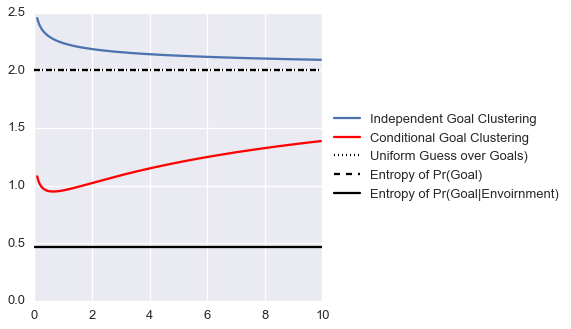

In [66]:
def comp_mi_conflict4(N, n):
    context_goals = [0] * N + [1] * N + [2] * N + [3] * N
    context_maps =  [0] * n + ([1, 2, 3] * 4)[:N-n] + \
                    [1] * n + ([2, 3, 0] * 4)[:N-n] + \
                    [2] * n + ([3, 0, 1] * 4)[:N-n] + \
                    [3] * n + ([0, 1, 2] * 4)[:N-n]
    plot_evaluate_joint(context_goals, context_maps)
comp_mi_conflict4(10, 9)

Entropy H(Goal):           2.00
Entropy H(Enviornment):    2.00
Mutual Information I(G,E): 0.09


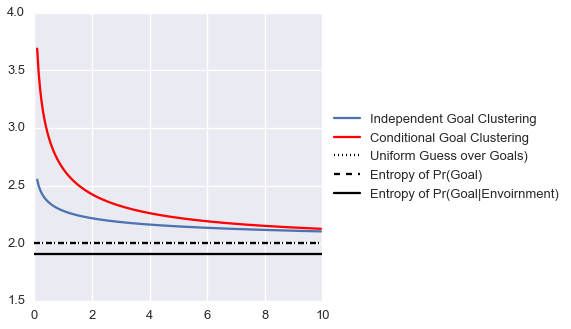

In [67]:
comp_mi_conflict4(8, 1)

Entropy H(Goal):           2.00
Entropy H(Enviornment):    2.00
Mutual Information I(G,E): 0.08


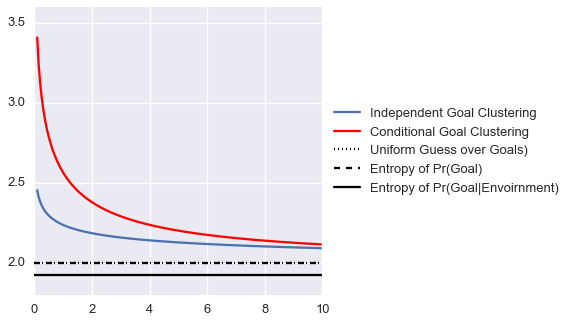

In [68]:
comp_mi_conflict4(10, 4)

Entropy H(Goal):           2.00
Entropy H(Enviornment):    2.00
Mutual Information I(G,E): 0.08


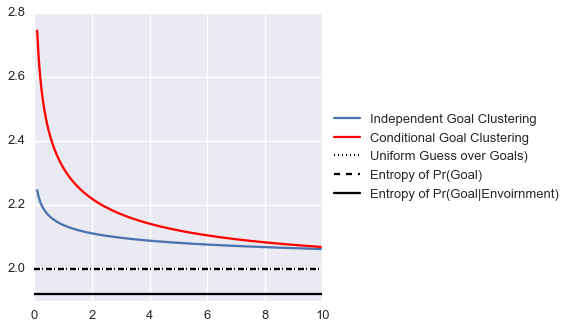

In [69]:
comp_mi_conflict4(20, 8)

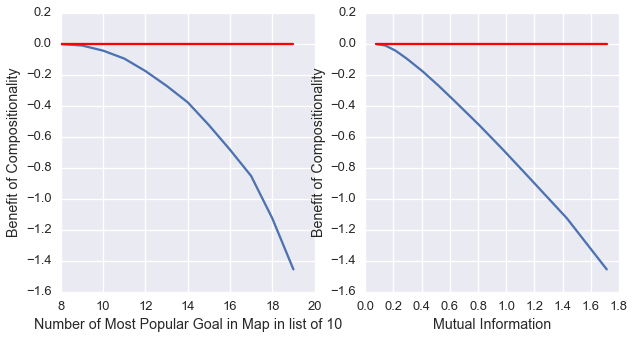

In [70]:
#minimize the alpha for each goal sequence
from scipy.optimize import minimize


N = 20
n_min = 8
n_conflict = range(n_min, N)
compositionality_benefit = list()
mutual_information_list = list()

for n in n_conflict:
    
    context_goals = [0] * N + [1] * N + [2] * N + [3] * N
    context_maps =  [0] * n + ([1, 2, 3] * 4)[:N-n] + \
                    [1] * n + ([2, 3, 0] * 4)[:N-n] + \
                    [2] * n + ([3, 0, 1] * 4)[:N-n] + \
                    [3] * n + ([0, 1, 2] * 4)[:N-n]
    def f0(alpha):
        return evaluate(context_goals, alpha=alpha)
    res0 = minimize(f0, 1.0)
    
    def f1(alpha):
        return evaluate_joint(context_goals, context_maps, alpha=alpha)
    res1 = minimize(f1, 1.0)
    
    mutual_information_list.append(mutual_information(context_goals, context_maps))
    
    compositionality_benefit.append(res1.fun - res0.fun)
    h_p.append(list_entropy(context_goals))
    

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(n_conflict, compositionality_benefit)
axes[0].plot(n_conflict, [0]*len(n_conflict), 'r')
axes[0].set_ylabel('Benefit of Compositionality')
axes[0].set_xlabel('Number of Most Popular Goal in Map in list of 10')

axes[1].plot(mutual_information_list, compositionality_benefit)
axes[1].plot(mutual_information_list, [0]*len(mutual_information_list), 'r')
axes[1].set_ylabel('Benefit of Compositionality')
axes[1].set_xlabel('Mutual Information')

In [ ]:
N = 10
n = 5
(range(1,4) * 4)[:N-n]

In [ ]:
N = 10
n = 4
context_goals = [0] * N + [1] * N + [2] * N + [3] * N
context_maps =  [0] * n + ([1, 2, 3] * 4)[:N-n] + \
                [1] * n + ([2, 3, 0] * 4)[:N-n] + \
                [2] * n + ([3, 0, 1] * 4)[:N-n] + \
                [3] * n + ([0, 1, 2] * 4)[:N-n]
list_entropy(context_maps)

### Appendix Derivation of the bias of the CRP
CRP:
$$q(k) =\Pr\left (c_{t+1} = k| c_{1:t} \right ) = 
\begin{cases} 
N_k/A & \quad \text{if } k < K_t \\
\alpha/A & \quad \text{if } k_K+1 \\
\end{cases}
$$

bias for $k \in K$:

$\begin{align}
\text{Bias}_{p_k}[q_k] 
    &= \mathbb{E}\left [\frac{N_k}{\alpha + N_c}\right ] - p_k \\
    \\
    &= \frac{p_k N_c}{\alpha + N_c} - \frac{p_k(\alpha + N_c)}{\alpha + N_c} \\
    \\
    &= p_k\frac{-\alpha}{\alpha + N_c}\\
\end{align}
$ 



$\\\text{Bias}_p[q] = \sum_{k\in K} \text{Bias}_p[q] = \sum_{k\in K}p_k\frac{-\alpha}{\alpha + N_c} = \frac{-\alpha}{\alpha + N_c}$

